# Introduction

We are tasked with training a feed forward neural network using only Pandas and Numpy on the Fashion MNIST dataset. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
wandb.login()

2023-03-18 16:18:13.706215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib
2023-03-18 16:18:13.706233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs20b075. Use `wandb login --relogin` to force relogin


True

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
p = np.random.RandomState(seed=42).permutation(len(x_train))
x_train, y_train = x_train[p], y_train[p]
train_length = int(0.9 * len(x_train))

x_train, x_val = np.split(x_train, [train_length])
y_train, y_val = np.split(y_train, [train_length])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(54000, 28, 28)
(54000,)
(10000, 28, 28)
(10000,)


## Question 1

Plot one image of every class present in the MNIST dataset.

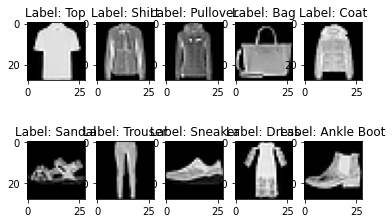

In [4]:
label_map = {0:"Top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}
seen_datasets = set()
wandb.init()
figure, axis = plt.subplots(2, 5)
unique_images = []
for index in range(len(x_train)):
    image = x_train[index]
    label = y_train[index]
    if label not in seen_datasets:
        seen_datasets.add(label)
        axis[label%2, label%5].imshow(image, cmap='gray')
        axis[label%2, label%5].set_title(f"Label: {label_map[label]}")
        images = wandb.Image(image, caption=f"Label: {label_map[label]}")
        unique_images.append(images)
wandb.log({"examples": unique_images})


In [5]:
print(y_train[0])

8


In [6]:
def one_hot(X:np.ndarray):
            return np.eye(10)[X]

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sooraj/.local/lib/python3.10/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/sooraj/.local/lib/python3.10/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/sooraj/.local/lib/python3.10/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [7]:
x_train = x_train.reshape(x_train.shape[0], -1)
y_train  = one_hot(y_train)
x_val = x_val.reshape(x_val.shape[0], -1)
y_val  = one_hot(y_val)

In [8]:
one_hot([1, 2, 3])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [9]:
y_train.shape

(54000, 10)

In [10]:
import feedforwardnn

nn = feedforwardnn.FeedforwardNN(784, 10, [256]*5, "relu", "random", 0)
nn.fit(x_train, y_train, 0.0001, 10, 128)

Iteration:  0
Loss:  13.92686718451721
Iteration:  1
Loss:  9.909334781756172
Iteration:  2
Loss:  8.719894219915302
Iteration:  3
Loss:  8.035732280584838
Iteration:  4
Loss:  7.51309930644264
Iteration:  5
Loss:  7.032517261254411
Iteration:  6
Loss:  6.796898564099629
Iteration:  7
Loss:  6.447141631212641
Iteration:  8
Loss:  6.210187983932332
Iteration:  9
Loss:  5.9158314812545445


In [11]:
x_test = x_test.reshape(x_test.shape[0], -1)
count = 0
print("Accuracy ", nn.accuracy(y_val, nn.predict(x_val)))

Accuracy  0.7991666666666667


In [12]:
nn.mean_squared_error(y_val, nn.predict(x_val))

# Wandb part!

In [13]:
import wandb 

def train(nn:feedforwardnn.FeedforwardNN, opt, config):
    num_epochs= config.epochs

    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        opt.zero_grad()
        print("Iteration ", epoch+1, " of ", num_epochs)
        for index in range(0, len(x_train), config.batch):
            nn.parameters.x_row = x_train[index:index+config.batch]
            nn.parameters.y_row = y_train[index:index+config.batch]
            nn.forward(nn.parameters.x_row)
            nn.backward()
            opt.step()
        y_iter_pred = nn.predict(x_train)
        train_loss = nn.cross_entropy_loss(y_train, y_iter_pred, regularization=True)
        train_accuracy = nn.accuracy(y_train, y_iter_pred)
        y_iter_pred = nn.predict(x_val)
        val_loss = nn.cross_entropy_loss(y_val, y_iter_pred)
        val_accuracy = nn.accuracy(y_val, y_iter_pred)
        val_mse_loss = nn.mean_squared_error(y_val, y_iter_pred)
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "val_mse_loss":val_mse_loss, "epoch": epoch})
        print("Train Loss: ", train_loss, " Train Accuracy: ", train_accuracy, " Val Loss: ", val_loss, " Val Accuracy: ", val_accuracy)


def wandb_sweep():
        wandb.init(project="assignment-1")
        # cf = wandb.config
        # wandb_run_name = "hl_"+cf.hidden_layer_size+"_nhl_"+cf.num_hidden_layers+"_af_"+cf.activation_function+"_wi_"+cf.weight_initialisation+"_wd_"+cf.weight_decay+"_opt_"+cf.optimizer+"_lr_"+cf.learning_rate+"_bs_"+cf.batch+"_ep_"+cf.epochs
        nn = feedforwardnn.FeedforwardNN(784, 10, [wandb.config.hidden_layer_size]*wandb.config.num_hidden_layers, wandb.config.activation_function, wandb.config.weight_initialisation, wandb.config.weight_decay)
        opt_map = {"sgd": feedforwardnn.SGD, "momentum": feedforwardnn.Momentum, "nesterov": feedforwardnn.NAG, "rmsprop": feedforwardnn.RMSProp, "adam": feedforwardnn.Adam, "nadam": feedforwardnn.NAdam}
        opt = opt_map[wandb.config.optimizer](nn.get_params(), wandb.config.learning_rate)
        train(nn, opt, wandb.config)

In [14]:
sweep_config = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "val_accuracy"},
    "parameters": {
        "hidden_layer_size": {"values": [32, 64, 128, 256]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "learning_rate": {"values": [0.001, 0.0001]},
        "batch": {"values": [16, 32, 64]},
        "epochs": {"values": [5, 10]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "activation_function": {"values": ["sigmoid", "tanh", "relu"]},
        "weight_decay": {"values": [0, 0.0005 , 0.05, 0.5]},
        "weight_initialisation": {"values": ["xavier", "random"]},
    }
}
sweep_id = wandb.sweep(sweep=sweep_config, project="assignment-1")
wandb.agent(sweep_id=sweep_id, function=wandb_sweep, count=20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: h84a40ar
Sweep URL: https://wandb.ai/cs20b075/assignment-1/sweeps/h84a40ar


wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run crimson-dragon-45 at: https://wandb.ai/cs20b075/assignment-1/runs/0pr6wyin
wandb: Synced 5 W&B file(s), 10 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230318_161819-0pr6wyin/logs
wandb: Agent Starting Run: tl0lni8m with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.6124928493447095  Train Accuracy:  0.8143518518518519  Val Loss:  0.6733558412638149  Val Accuracy:  0.8041666666666667
Epoch:  2
Iteration  2  of  5
Train Loss:  0.5481492400279059  Train Accuracy:  0.8268703703703704  Val Loss:  0.5893353211164671  Val Accuracy:  0.815
Epoch:  3
Iteration  3  of  5
Train Loss:  0.46120748403904  Train Accuracy:  0.8505370370370371  Val Loss:  0.520282000224378  Val Accuracy:  0.835
Epoch:  4
Iteration  4  of  5
Train Loss:  0.4123194432481411  Train Accuracy:  0.861537037037037  Val Loss:  0.4691511392425057  Val Accuracy:  0.8495
Epoch:  5
Iteration  5  of  5
Train Loss:  0.39077321215466687  Train Accuracy:  0.8696111111111111  Val Loss:  0.44783549704326137  Val Accuracy:  0.8525


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▆▃▂▁
val_accuracy,▁▃▅██
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.86961
train_loss,0.39077
val_accuracy,0.8525
val_loss,0.44784


wandb: Agent Starting Run: n6yzjnvm with config:
wandb: 	activation_function: tanh
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.947377298175879  Train Accuracy:  0.6057777777777777  Val Loss:  0.9557845604650989  Val Accuracy:  0.5998333333333333
Epoch:  2
Iteration  2  of  5
Train Loss:  1.101151342909883  Train Accuracy:  0.5287592592592593  Val Loss:  1.120957744546562  Val Accuracy:  0.5261666666666667
Epoch:  3
Iteration  3  of  5
Train Loss:  1.2451319592805983  Train Accuracy:  0.46885185185185185  Val Loss:  1.252388427998042  Val Accuracy:  0.468
Epoch:  4
Iteration  4  of  5
Train Loss:  1.2770418947893412  Train Accuracy:  0.44251851851851853  Val Loss:  1.2931535737908804  Val Accuracy:  0.4385
Epoch:  5
Iteration  5  of  5
Train Loss:  1.1739792359073347  Train Accuracy:  0.49994444444444447  Val Loss:  1.1895422391497643  Val Accuracy:  0.49383333333333335


epoch,▁▃▅▆█
train_accuracy,█▅▂▁▃
train_loss,▁▄▇█▆
val_accuracy,█▅▂▁▃
val_loss,▁▄▇█▆
epoch,4
train_accuracy,0.49994
train_loss,1.17398
val_accuracy,0.49383
val_loss,1.18954


wandb: Agent Starting Run: 002j98yr with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:222: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train Loss:  0.9058478429684564  Train Accuracy:  0.6747222222222222  Val Loss:  0.9011136476813155  Val Accuracy:  0.664
Epoch:  2
Iteration  2  of  10
Train Loss:  0.6965647265936757  Train Accuracy:  0.7478518518518519  Val Loss:  0.6999614265548989  Val Accuracy:  0.744
Epoch:  3
Iteration  3  of  10
Train Loss:  0.6464871734939042  Train Accuracy:  0.7572777777777778  Val Loss:  0.6492477119391243  Val Accuracy:  0.7483333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.6587425304321739  Train Accuracy:  0.7575185185185185  Val Loss:  0.6629868738264206  Val Accuracy:  0.7488333333333334
Epoch:  5
Iteration  5  of  10
Train Loss:  0.7105994810815869  Train Accuracy:  0.730574074074074  Val Loss:  0.7222627479488576  Val Accuracy:  0.7213333333333334
Epoch:  6
Iteration  6  of  10
Train Loss:  0.734365281855151  Train Accuracy:  0.709925925925926  Val Loss:  0.7501112151310552  Val Accuracy:  0.7008333333333333
Epoch:  7
Iteration  7  of  10
Train Loss:  0.7243868713688169  

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇██▆▄▅▄▆▄
train_loss,█▂▁▁▃▃▃▄▃▄
val_accuracy,▁███▆▄▅▄▆▅
val_loss,█▂▁▁▃▄▃▄▃▄
epoch,9
train_accuracy,0.71231
train_loss,0.75276
val_accuracy,0.7095
val_loss,0.76464


wandb: Agent Starting Run: x5p3joam with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:222: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train Loss:  1.3381068186457128  Train Accuracy:  0.5479444444444445  Val Loss:  1.350499077013909  Val Accuracy:  0.5385
Epoch:  2
Iteration  2  of  5
Train Loss:  1.140990669005902  Train Accuracy:  0.5801666666666667  Val Loss:  1.1351260421505849  Val Accuracy:  0.5883333333333334
Epoch:  3
Iteration  3  of  5
Train Loss:  1.028538672930442  Train Accuracy:  0.6173888888888889  Val Loss:  1.022889744900481  Val Accuracy:  0.6248333333333334
Epoch:  4
Iteration  4  of  5
Train Loss:  1.0125745029019648  Train Accuracy:  0.6150185185185185  Val Loss:  1.0156238204108399  Val Accuracy:  0.619
Epoch:  5
Iteration  5  of  5
Train Loss:  0.939202146306714  Train Accuracy:  0.6648148148148149  Val Loss:  0.9416404372120516  Val Accuracy:  0.6638333333333334


epoch,▁▃▅▆█
train_accuracy,▁▃▅▅█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▅█
val_loss,█▄▂▂▁
epoch,4
train_accuracy,0.66481
train_loss,0.9392
val_accuracy,0.66383
val_loss,0.94164


wandb: Agent Starting Run: 9mih1ooc with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.681348715290361  Train Accuracy:  0.8148703703703704  Val Loss:  0.7553557089258213  Val Accuracy:  0.8015
Epoch:  2
Iteration  2  of  10
Train Loss:  0.47912550720430797  Train Accuracy:  0.8426111111111111  Val Loss:  0.542135361068636  Val Accuracy:  0.8318333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.4114816128173267  Train Accuracy:  0.8591481481481481  Val Loss:  0.4715252823378667  Val Accuracy:  0.8453333333333334
Epoch:  4
Iteration  4  of  10
Train Loss:  0.38456837404798405  Train Accuracy:  0.8659259259259259  Val Loss:  0.4460079283110919  Val Accuracy:  0.8513333333333334
Epoch:  5
Iteration  5  of  10
Train Loss:  0.34583781303222416  Train Accuracy:  0.8775185185185185  Val Loss:  0.40313304235915326  Val Accuracy:  0.8583333333333333
Epoch:  6
Iteration  6  of  10
Train Loss:  0.35105027272204486  Train Accuracy:  0.8754259259259259  Val Loss:  0.4156749545462131  Val Accuracy:  0.8555
Epoch:  7
Iteration  7  o

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.888
train_loss,0.30842
val_accuracy,0.8685
val_loss,0.37096


wandb: Agent Starting Run: il8nlhbl with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.6208758741575361  Train Accuracy:  0.8138888888888889  Val Loss:  0.6734453085440345  Val Accuracy:  0.8035
Epoch:  2
Iteration  2  of  10
Train Loss:  0.47007938941497884  Train Accuracy:  0.8362777777777778  Val Loss:  0.5075997206110435  Val Accuracy:  0.8236666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  0.39856231535276065  Train Accuracy:  0.8559074074074075  Val Loss:  0.42795517156658086  Val Accuracy:  0.8428333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3881840487555442  Train Accuracy:  0.8602037037037037  Val Loss:  0.4188856783338767  Val Accuracy:  0.8493333333333334
Epoch:  5
Iteration  5  of  10
Train Loss:  0.36545741320466374  Train Accuracy:  0.8675  Val Loss:  0.3969355333473819  Val Accuracy:  0.8585
Epoch:  6
Iteration  6  of  10
Train Loss:  0.35185975038333317  Train Accuracy:  0.8733333333333333  Val Loss:  0.3833456154227024  Val Accuracy:  0.8646666666666667
Epoch:  7
Iteration  7  of  10
Trai

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇█▇▇██
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▃▆▆▇█▇▇▇█
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,9
train_accuracy,0.87485
train_loss,0.35001
val_accuracy,0.86233
val_loss,0.38403


wandb: Agent Starting Run: ji05uhog with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10


wandb: ERROR Run ji05uhog errored: AssertionError('Weights are NaN')
wandb: Agent Starting Run: q00vmpcy with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.6229404756028555  Train Accuracy:  0.7843333333333333  Val Loss:  0.6699461290863896  Val Accuracy:  0.7758333333333334
Epoch:  2
Iteration  2  of  10
Train Loss:  0.46573626064833007  Train Accuracy:  0.8351111111111111  Val Loss:  0.5002348425569416  Val Accuracy:  0.8275
Epoch:  3
Iteration  3  of  10
Train Loss:  0.40819205014251586  Train Accuracy:  0.8513148148148149  Val Loss:  0.4449762882465353  Val Accuracy:  0.838
Epoch:  4
Iteration  4  of  10
Train Loss:  0.37558987889950646  Train Accuracy:  0.863462962962963  Val Loss:  0.4221559870455589  Val Accuracy:  0.8465
Epoch:  5
Iteration  5  of  10
Train Loss:  0.3595819602816523  Train Accuracy:  0.8694259259259259  Val Loss:  0.4101336192144849  Val Accuracy:  0.853
Epoch:  6
Iteration  6  of  10
Train Loss:  0.3483418092174196  Train Accuracy:  0.872537037037037  Val Loss:  0.40112789955306477  Val Accuracy:  0.8561666666666666
Epoch:  7
Iteration  7  of  10
Train Loss:  0.339176

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,9
train_accuracy,0.88094
train_loss,0.31777
val_accuracy,0.85867
val_loss,0.39964


wandb: Agent Starting Run: v6ratbjx with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.49414765001300065  Train Accuracy:  0.8214814814814815  Val Loss:  0.5107841443949772  Val Accuracy:  0.8098333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  0.45684430054551406  Train Accuracy:  0.8342222222222222  Val Loss:  0.479459726812506  Val Accuracy:  0.8266666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  0.41243892930362464  Train Accuracy:  0.8482407407407407  Val Loss:  0.43571066891165294  Val Accuracy:  0.8403333333333334
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3878638010695461  Train Accuracy:  0.8534814814814815  Val Loss:  0.41245865878866433  Val Accuracy:  0.8406666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  0.3891503153801695  Train Accuracy:  0.8553703703703703  Val Loss:  0.41444921428576226  Val Accuracy:  0.8426666666666667
Epoch:  6
Iteration  6  of  10
Train Loss:  0.37316101929684625  Train Accuracy:  0.8636851851851852  Val Loss:  0.41194359447703693  Val Accuracy:  0.85183333333333

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇████
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▇▇█▇
val_loss,█▆▄▂▃▂▂▂▁▂
epoch,9
train_accuracy,0.86561
train_loss,0.36179
val_accuracy,0.85433
val_loss,0.39577


wandb: Agent Starting Run: 68en4a7w with config:
wandb: 	activation_function: tanh
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.678057627691928  Train Accuracy:  0.7564444444444445  Val Loss:  0.6859912395003294  Val Accuracy:  0.7495
Epoch:  2
Iteration  2  of  5
Train Loss:  0.6701890231094244  Train Accuracy:  0.7501851851851852  Val Loss:  0.6789470987226347  Val Accuracy:  0.7456666666666667
Epoch:  3
Iteration  3  of  5
Train Loss:  0.6500557648648866  Train Accuracy:  0.7587592592592592  Val Loss:  0.6582009578901586  Val Accuracy:  0.7533333333333333
Epoch:  4
Iteration  4  of  5
Train Loss:  0.6813503953667942  Train Accuracy:  0.7411481481481481  Val Loss:  0.6927568467558258  Val Accuracy:  0.7333333333333333
Epoch:  5
Iteration  5  of  5
Train Loss:  0.6438941468557665  Train Accuracy:  0.7663148148148148  Val Loss:  0.6518697210139732  Val Accuracy:  0.7585


epoch,▁▃▅▆█
train_accuracy,▅▄▆▁█
train_loss,▇▆▂█▁
val_accuracy,▅▄▇▁█
val_loss,▇▆▂█▁
epoch,4
train_accuracy,0.76631
train_loss,0.64389
val_accuracy,0.7585
val_loss,0.65187


wandb: Agent Starting Run: txyk0y7z with config:
wandb: 	activation_function: tanh
wandb: 	batch: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.7133912428283607  Train Accuracy:  0.737537037037037  Val Loss:  0.7300993654669043  Val Accuracy:  0.729
Epoch:  2
Iteration  2  of  5
Train Loss:  0.6879317343992183  Train Accuracy:  0.7379629629629629  Val Loss:  0.6959308911906628  Val Accuracy:  0.7385
Epoch:  3
Iteration  3  of  5
Train Loss:  0.649879116284041  Train Accuracy:  0.7558333333333334  Val Loss:  0.6614496153592588  Val Accuracy:  0.7488333333333334
Epoch:  4
Iteration  4  of  5
Train Loss:  0.6297014955278942  Train Accuracy:  0.7629259259259259  Val Loss:  0.6342319485979059  Val Accuracy:  0.759
Epoch:  5
Iteration  5  of  5
Train Loss:  0.6557967635050976  Train Accuracy:  0.753537037037037  Val Loss:  0.6672229791452664  Val Accuracy:  0.747


epoch,▁▃▅▆█
train_accuracy,▁▁▆█▅
train_loss,█▆▃▁▃
val_accuracy,▁▃▆█▅
val_loss,█▆▃▁▃
epoch,4
train_accuracy,0.75354
train_loss,0.6558
val_accuracy,0.747
val_loss,0.66722


wandb: Agent Starting Run: us9xyw32 with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:340: RuntimeWarning: overflow encountered in square
  loss += self.weight_decay * sum([np.sum(np.square(w)) for w in self.parameters.weights[1:]])/(2*sum([w.size for w in self.parameters.weights[1:]]))
/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:340: RuntimeWarning: invalid value encountered in double_scalars
  loss += self.weight_decay * sum([np.sum(np.square(w)) for w in self.parameters.weights[1:]])/(2*sum([w.size for w in self.parameters.weights[1:]]))


Train Loss:  nan  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  nan  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  nan  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  nan  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  nan  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  6
Iteration  6  of  10
Train Loss:  nan  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  7
Iteration  7  of  10
Train Loss:  nan  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.10026
train_loss,nan
val_accuracy,0.09767
val_loss,2.30259


wandb: Agent Starting Run: dalraw41 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:222: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train Loss:  2.6399323951067086  Train Accuracy:  0.4168148148148148  Val Loss:  2.6932562945497804  Val Accuracy:  0.4151666666666667
Epoch:  2
Iteration  2  of  5
Train Loss:  1.369464744233537  Train Accuracy:  0.6062222222222222  Val Loss:  1.4159104448941315  Val Accuracy:  0.5986666666666667
Epoch:  3
Iteration  3  of  5
Train Loss:  1.0373240355961624  Train Accuracy:  0.6622407407407407  Val Loss:  1.0786782220114994  Val Accuracy:  0.6548333333333334
Epoch:  4
Iteration  4  of  5
Train Loss:  0.882944652583948  Train Accuracy:  0.7043888888888888  Val Loss:  0.941195567452357  Val Accuracy:  0.6788333333333333
Epoch:  5
Iteration  5  of  5
Train Loss:  0.8016166352669891  Train Accuracy:  0.7218888888888889  Val Loss:  0.849350503936766  Val Accuracy:  0.7068333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▃▂▁▁
epoch,4
train_accuracy,0.72189
train_loss,0.80162
val_accuracy,0.70683
val_loss,0.84935


wandb: Agent Starting Run: kjrkoz2d with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:222: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train Loss:  0.8258586509935752  Train Accuracy:  0.7082407407407407  Val Loss:  0.8261919195402947  Val Accuracy:  0.699
Epoch:  2
Iteration  2  of  5
Train Loss:  1.0274068490036623  Train Accuracy:  0.6758888888888889  Val Loss:  1.0321868398750291  Val Accuracy:  0.669
Epoch:  3
Iteration  3  of  5
Train Loss:  1.061029556250803  Train Accuracy:  0.6691481481481482  Val Loss:  1.065957793234428  Val Accuracy:  0.663
Epoch:  4
Iteration  4  of  5
Train Loss:  1.036952607093278  Train Accuracy:  0.6787592592592593  Val Loss:  1.040600511320189  Val Accuracy:  0.675
Epoch:  5
Iteration  5  of  5
Train Loss:  1.0317660539587654  Train Accuracy:  0.6773333333333333  Val Loss:  1.0328826015987989  Val Accuracy:  0.676


epoch,▁▃▅▆█
train_accuracy,█▂▁▃▂
train_loss,▁▇█▇▇
val_accuracy,█▂▁▃▄
val_loss,▁▇█▇▇
epoch,4
train_accuracy,0.67733
train_loss,1.03177
val_accuracy,0.676
val_loss,1.03288


wandb: Agent Starting Run: klz9zetz with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:222: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train Loss:  0.8713234517987113  Train Accuracy:  0.6936296296296296  Val Loss:  0.8811007993570706  Val Accuracy:  0.6876666666666666
Epoch:  2
Iteration  2  of  5
Train Loss:  0.7860900282530897  Train Accuracy:  0.7072407407407407  Val Loss:  0.7931004569479223  Val Accuracy:  0.7015
Epoch:  3
Iteration  3  of  5
Train Loss:  0.8307051810480914  Train Accuracy:  0.6843888888888889  Val Loss:  0.8353278363873973  Val Accuracy:  0.6831666666666667
Epoch:  4
Iteration  4  of  5
Train Loss:  0.7852003669790226  Train Accuracy:  0.6987037037037037  Val Loss:  0.7930163887601807  Val Accuracy:  0.6936666666666667
Epoch:  5
Iteration  5  of  5
Train Loss:  1.0306826319336881  Train Accuracy:  0.6218703703703704  Val Loss:  1.0209569889943986  Val Accuracy:  0.6195


epoch,▁▃▅▆█
train_accuracy,▇█▆▇▁
train_loss,▃▁▂▁█
val_accuracy,▇█▆▇▁
val_loss,▄▁▂▁█
epoch,4
train_accuracy,0.62187
train_loss,1.03068
val_accuracy,0.6195
val_loss,1.02096


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ks7or06 with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  2.3025850929940432  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  2
Iteration  2  of  5
Train Loss:  2.3025850929940432  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  3
Iteration  3  of  5
Train Loss:  2.3025850929940432  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  4
Iteration  4  of  5
Train Loss:  2.3025850929940432  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  5
Iteration  5  of  5
Train Loss:  2.3025850929940432  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,4
train_accuracy,0.10026
train_loss,2.30259
val_accuracy,0.09767
val_loss,2.30259


wandb: Agent Starting Run: 2mybz7ay with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  12.350776844950243  Train Accuracy:  0.6641851851851852  Val Loss:  11.95447837405719  Val Accuracy:  0.6683333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  9.65714778510519  Train Accuracy:  0.7384074074074074  Val Loss:  9.791859170698938  Val Accuracy:  0.7283333333333334
Epoch:  3
Iteration  3  of  10
Train Loss:  9.421059134609518  Train Accuracy:  0.7441851851851852  Val Loss:  9.7858518951449  Val Accuracy:  0.7285
Epoch:  4
Iteration  4  of  10
Train Loss:  9.421570022024477  Train Accuracy:  0.7433148148148148  Val Loss:  9.852683976580348  Val Accuracy:  0.7263333333333334
Epoch:  5
Iteration  5  of  10
Train Loss:  8.702722709857218  Train Accuracy:  0.7626851851851851  Val Loss:  9.083934020956006  Val Accuracy:  0.7476666666666667
Epoch:  6
Iteration  6  of  10
Train Loss:  9.144541853516758  Train Accuracy:  0.7499259259259259  Val Loss:  9.584959494170782  Val Accuracy:  0.7335
Epoch:  7
Iteration  7  of  10
Train Loss:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇██████▆▃▁
train_loss,█▆▆▆▅▆▅▂▂▁
val_accuracy,▇██████▆▃▁
val_loss,█▆▆▆▆▆▆▃▂▁
epoch,9
train_accuracy,0.17013
train_loss,2.3234
val_accuracy,0.17083
val_loss,2.27342


wandb: Agent Starting Run: zmdi8rtn with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:222: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train Loss:  3.30927997161944  Train Accuracy:  0.1875740740740741  Val Loss:  3.102904713981172  Val Accuracy:  0.18733333333333332
Epoch:  2
Iteration  2  of  5
Train Loss:  2.18456758715119  Train Accuracy:  0.3264444444444444  Val Loss:  2.0125194667223893  Val Accuracy:  0.3233333333333333
Epoch:  3
Iteration  3  of  5
Train Loss:  1.825929957010287  Train Accuracy:  0.4265185185185185  Val Loss:  1.6749674854199288  Val Accuracy:  0.41783333333333333
Epoch:  4
Iteration  4  of  5
Train Loss:  1.6061330157723994  Train Accuracy:  0.49287037037037035  Val Loss:  1.4644810966581043  Val Accuracy:  0.4861666666666667
Epoch:  5
Iteration  5  of  5
Train Loss:  1.4519773705537307  Train Accuracy:  0.5446111111111112  Val Loss:  1.3167827884303214  Val Accuracy:  0.5398333333333334


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▂▁
epoch,4
train_accuracy,0.54461
train_loss,1.45198
val_accuracy,0.53983
val_loss,1.31678


wandb: Agent Starting Run: hrry85ll with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10


/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:222: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train Loss:  0.7470486188195058  Train Accuracy:  0.7185925925925926  Val Loss:  0.7532844933586774  Val Accuracy:  0.7165
Epoch:  2
Iteration  2  of  10
Train Loss:  0.6834036257639133  Train Accuracy:  0.7436851851851852  Val Loss:  0.6958459875893257  Val Accuracy:  0.7388333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.6681705312004542  Train Accuracy:  0.7496296296296296  Val Loss:  0.6886469852867029  Val Accuracy:  0.7415
Epoch:  4
Iteration  4  of  10
Train Loss:  0.642312268044837  Train Accuracy:  0.7561481481481481  Val Loss:  0.6659060123199354  Val Accuracy:  0.7481666666666666
Epoch:  5
Iteration  5  of  10
Train Loss:  0.6210074338684848  Train Accuracy:  0.7632592592592593  Val Loss:  0.641754163577317  Val Accuracy:  0.7551666666666667
Epoch:  6
Iteration  6  of  10
Train Loss:  0.5995718177712144  Train Accuracy:  0.7706666666666667  Val Loss:  0.621620636783705  Val Accuracy:  0.7636666666666667
Epoch:  7
Iteration  7  of  10
Train Loss:  0.5653543562950956

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▅▇▇▇█
train_loss,█▆▅▅▄▃▂▁▁▁
val_accuracy,▁▃▃▄▄▅▇█▇█
val_loss,█▆▆▅▄▃▂▂▂▁
epoch,9
train_accuracy,0.80459
train_loss,0.53002
val_accuracy,0.79467
val_loss,0.54971


wandb: Agent Starting Run: 7aqp3jw0 with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  1.2868943436738114e+195  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  1.2442855871550467e+195  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  1.2030875961284005e+195  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  1.1632536604939883e+195  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  1.1247386167118653e+195  Train Accuracy:  0.10025925925925926  Val Loss:  2.3025850929940432  Val Accuracy:  0.09766666666666667
Epoch:  6
Iteration  6  of  10
Train Loss:  1.0874987965958425e+195  Train Accuracy:  0.10025925925925926  Val Loss:  2.302585092994043

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.10026
train_loss,9.504679993131301e+194
val_accuracy,0.09767
val_loss,2.30259


Error in callback <function _WandbInit._pause_backend at 0x7f32ce110ee0> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe